In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from modeling_functions import evaluate_model, plot_features_importance

df = pd.read_parquet('data/2023/for_ml_model.parquet')
df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()

# Feature selection

In [23]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Święto',
    'Dzień tygodnia',
    'Godzina',
    'Miesiąc'
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

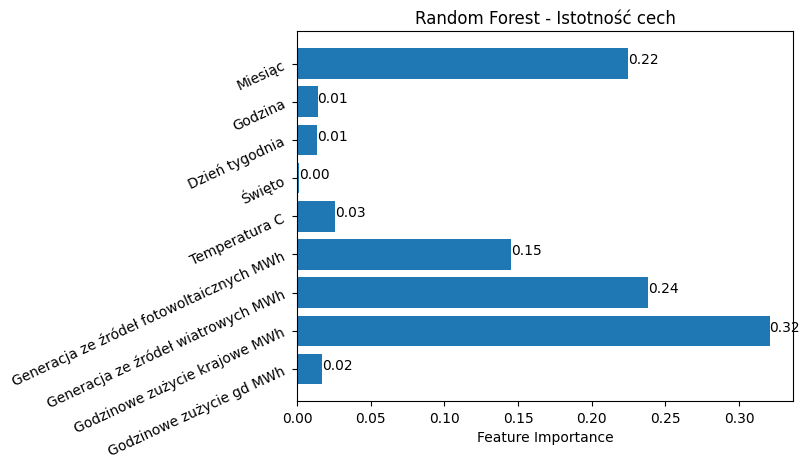

In [24]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')


[]

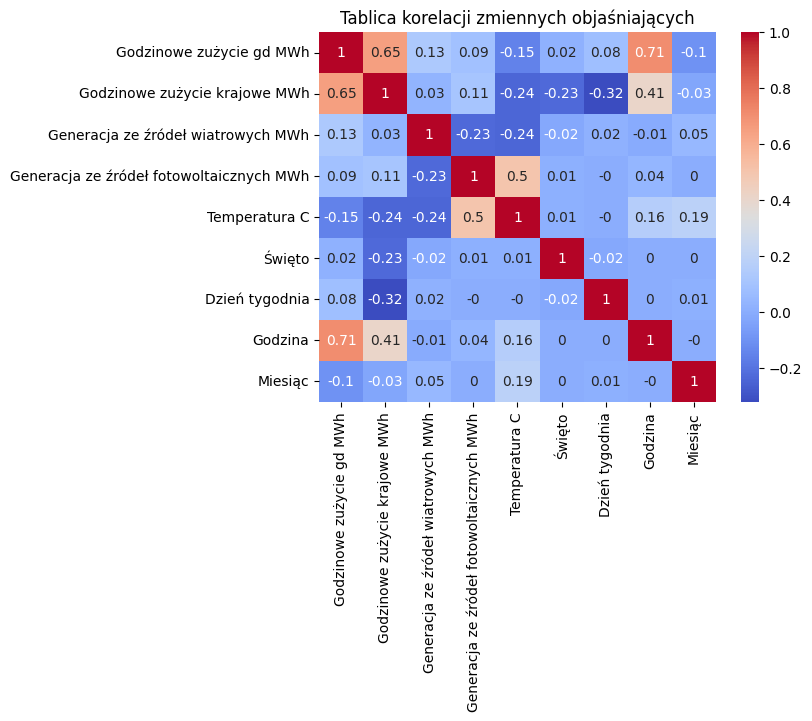

In [25]:
sns.heatmap(X.corr().round(2), cmap='coolwarm', annot=True)
plt.title("Tablica korelacji zmiennych objaśniających")
plt.plot()

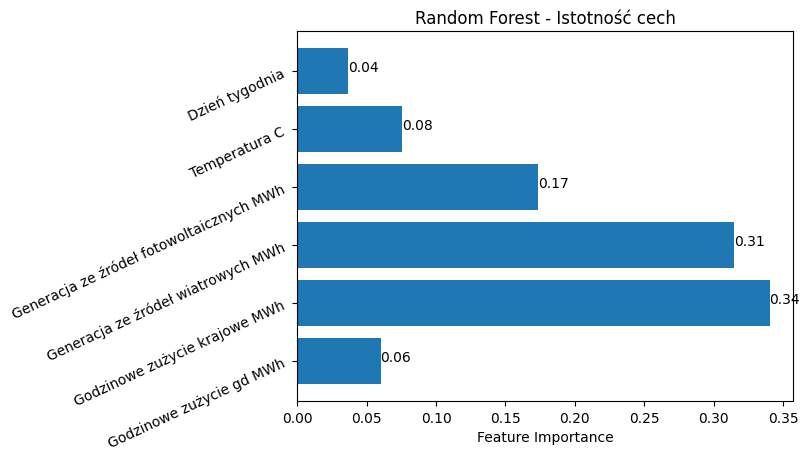

In [28]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    # 'Święto',
    'Dzień tygodnia',
    # 'Godzina',
    # 'Miesiąc'
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

feature_importance = rf.feature_importances_
features = X.columns

plot_features_importance(features, feature_importance, 'Random Forest')

# 2 uczenie

In [29]:
X = df[[
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Temperatura C',
    'Dzień tygodnia',
]]

y = df['Cena PLN/MWh']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## 2.1 Random Forest

In [10]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Las losowy", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.7


## 2.2 Support Vector Machine (SVM)

### Strojenie hiperparametrów

In [30]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# attempt 1
param_grid = {
    'svr__C': [
        1, 10, 50, 100, 200, 500, 1000
    ],
    'svr__gamma': [0.1, 1, 2, 3],
    'svr__epsilon': [1, 10, 30, 60, 90]
}
svr = make_pipeline(StandardScaler(), SVR())
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)


c:\python311\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'svr__C': 500, 'svr__epsilon': 30, 'svr__gamma': 1}


In [31]:
# attempt 2
param_grid = {
    'svr__C': [
         300, 400, 500, 600, 700
    ],
    'svr__gamma': [0.5, 1, 1.5],
    'svr__epsilon': [10, 20, 30, 40]
}
svr = make_pipeline(StandardScaler(), SVR())
grid_search = GridSearchCV(svr, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

Best parameters: {'svr__C': 400, 'svr__epsilon': 30, 'svr__gamma': 1.5}


In [13]:
svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))
# svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=150, gamma=1))
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Support Vector Machine", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.70
0,Support Vector Machine,True,0.80,58.37,79.84


## 2.3 Gradient Boosting Machines (GBM)

In [14]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(random_state=42)
gbm.fit(X_train, y_train)
y_pred = gbm.predict(X_test)

df_evaluate = evaluate_model(df_evaluate, y_test, y_pred, "Gradient Boosting Machines", with_gd=True)
df_evaluate

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
0,Las losowy,True,0.79,61.45,80.70
0,Support Vector Machine,True,0.80,58.37,79.84
0,Gradient Boosting Machines,True,0.74,72.12,90.03


# Final training

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from modeling_functions import evaluate_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor


df = pd.read_parquet('data/2023/for_ml_model.parquet')
# df.set_index('Data Godzina', inplace=True)

RANDOM_STATE = 42
TEST_SIZE = 0.3
df_evaluate = pd.DataFrame()


def create_model_random_forest(X_train, y_train):
    # Initialize and train Random Forest models
    rf = RandomForestRegressor(random_state=RANDOM_STATE)
    # Fit data
    rf.fit(X_train, y_train)

    return rf

def create_model_svm(X_train, y_train):
    # Standardize features and train SVM
    svr = make_pipeline(StandardScaler(), SVR(C=400, gamma=1.5, epsilon=30))
    # Fit data
    svr.fit(X_train, y_train)

    return svr

def create_model_gbm(X_train, y_train):
    gbm = GradientBoostingRegressor(random_state=RANDOM_STATE)
    # Fit data
    gbm.fit(X_train, y_train)
    
    return gbm

def create_model_mlp(X_train, y_train):

    mlp = MLPRegressor(random_state=RANDOM_STATE)
    mlp.fit(X_train, y_train)
    
    return mlp

def train_models_and_compare(df: pd.DataFrame, X_columns: list, with_gd: bool):
    X = df[X_columns].copy()
    y = df['Cena PLN/MWh']
    
    df_evaluate = pd.DataFrame()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    
    rf_model = create_model_random_forest(X_train, y_train)
    svm_model = create_model_svm(X_train, y_train)
    gbm_model = create_model_gbm(X_train, y_train)
    mlp_model = create_model_mlp(X_train, y_train)
    
    y_pred_rf = rf_model.predict(X_test)
    y_pred_svm = svm_model.predict(X_test)
    y_pred_gbr = gbm_model.predict(X_test)
    y_pred_mlp = mlp_model.predict(X_test)

    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_rf, "Random Forest", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_gbr, "Gradient Boosting Regressor", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_svm, "Support Vector Machine", with_gd)
    df_evaluate = evaluate_model(df_evaluate, y_test, y_pred_mlp, "Neural network", with_gd)
    
    return df_evaluate

In [39]:
X_gd_columns = [
    'Godzinowe zużycie gd MWh',
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Dzień tygodnia',
    'Temperatura C',
]

X_no_gd_columns = [
    'Godzinowe zużycie krajowe MWh', 
    'Generacja ze źródeł wiatrowych MWh', 
    'Generacja ze źródeł fotowoltaicznych MWh',
    'Dzień tygodnia',
    'Temperatura C',
]

df_evaluate_no_gd = train_models_and_compare(df, X_no_gd_columns, with_gd=False)
df_evaluate_with_gd = train_models_and_compare(df, X_gd_columns, with_gd=True)


In [40]:
df_result = pd.concat([df_evaluate_no_gd, df_evaluate_with_gd]).reset_index(drop=True).sort_values('Model')
df_result

,Model,Z gospodarstwami domowymi,R-Squared,Mean Absolute Error (MAE),Root Mean Squared Error (RMSE)
1,Gradient Boosting Regressor,False,0.74,72.80,90.85
5,Gradient Boosting Regressor,True,0.74,71.79,90.08
3,Neural network,False,0.69,81.71,99.23
7,Neural network,True,0.70,79.81,97.60
0,Random Forest,False,0.79,60.99,80.84
4,Random Forest,True,0.81,59.27,78.34
2,Support Vector Machine,False,0.79,59.25,81.04
6,Support Vector Machine,True,0.82,55.48,75.48


### Walidacja krzyżowa najlepszego modelu

In [52]:
from sklearn.model_selection import cross_val_score

y = df['Cena PLN/MWh']
X = df[X_gd_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)


best_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=800, gamma=1))

# Perform 5-fold cross-validation
cv_scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

# Display cross-validation results
print("Cross-validation R^2 scores:", cv_scores)
print("Mean R^2 score:", cv_scores.mean())
print("Standard deviation of R^2 scores:", cv_scores.std())

Cross-validation R^2 scores: [0.82834571 0.83750197 0.83148885 0.83606397 0.8242321 ]
Mean R^2 score: 0.8315265217625365
Standard deviation of R^2 scores: 0.004891258314324354
